In [1]:
### This is about simulating a great number of times the Velib trafic in Rouen
import Distributions
using Distributions
import PyPlot
using PyPlot

In [2]:
#General Data
T = 120 #horizon
n = 5 #number of stations : 3-7
dist_matrix = 1./[0 3 5 7 7;
               2 0 2 5 5;
               4 2 0 3 3;
               8 6 4 0 2;
               7 7 5 2 0]; #distance between stations
terminal_number = [24 20 20 15 20]; #number of terminals at each station
routing_matrix = [0 0.2 0.3 0.2 0.3;
                  0.2 0 0.3 0.2 0.3;
                  0.2 0.25 0 0.25 0.3;
                  0.15 0.2 0.3 0 0.35;
                  0.2 0.25 0.35 0.2 0]; #routing matrix ?
leaving_per_min = [2.8 3.7 5.5 3.5 4.6]/60; #mean number of bikes leaving each station per minute
leaving_per_hour = leaving_per_min;
alpha = 1;
N_bikes = convert(Integer, 91); #total number of bikes
N_stations = convert(Integer, 5); #number of stations

In [3]:
#Initial data
X0 = [20 1 0 0 0;
     1 15 1 0 0;
     0 1 17 1 0;
     0 0 1 13 1;
     0 0 0 1 18];

In [4]:
function get_event(v, P)
    i0 = 1; j0 = 1; s = 0;
    for i in range(1, N_stations)
        for j in range(1, N_stations)
            s = s + P[i,j];
            if P[i,j] != 0
                if v< s
                    i0 = i; j0 = j;
                    return [i0, j0];
                end
            end
        end
    end
    return [i0, j0]
end

get_event (generic function with 1 method)

In [153]:
function simulate(T, suivi=false, logs=false)
    #define distributions
    c = Uniform();
    route = [Categorical(routing_matrix[i, :]) for i in range(1, N_stations)];
    #time
    t = 0;
    #state
    X = copy(X0);
    #number of problems
    result = 0;
    last_state = 0;
    while (t < T)
        #********************************************************************
        #Get the parameter of the stay time Exponential 
        #get also the vector with probabilities of each event p
        lambda = 0;
        p = zeros(N_stations,N_stations);
        for i in range(1, N_stations)
            for j in range(1, N_stations)
                if i != j
                    lambda = lambda + X[i,j]*dist_matrix[i,j];
                    p[i,j] = X[i,j]*dist_matrix[i,j];
                    #println(X[i,j])
                else
                    lambda = lambda + alpha * leaving_per_hour[i];
                    p[i,j] = alpha * leaving_per_hour[i];
                end
                
                #println(i, " , ", j ," , " ,lambda)
            end
        end
        p = p./lambda;
        
        if logs
            for i in range(1,N_stations)
                println(p[i,:])
            end
            println("lambda ", lambda)
        end
        
        #*****************************************************************
        #Draw the time to stay
        exp = Exponential(1/lambda);
        dt = rand(exp);
        #println(dt)
        t = t + dt;
        
        #*****************************************************************
        #draw event and realise it
        cat = rand(c);
        if logs
            println(" cat ", cat)
            for i in range(1,N_stations)
                println(X[i,:])
            end
        end
        A = get_event(cat, p); i = A[1]; j = A[2];
        #println("i ", i, " j ", j)
        #println(p[i,j])
        #if i == j it is a departure. Else it is an arrival.
        if i == j
            #if there is no bike available
            if X[i,j] == 0
                result = result + 1;
                #last_state = 1;
                if suivi 
                    println("error departure " , i)
                end
            else
                X[i,j] = X[i,j] - 1;
                destination = rand(route[i]);
                X[i, destination] = X[i, destination] + 1;
                #last_state = 0;
            end
            if suivi
                println("departure ", i , " to ", destination, ", temps " , t);
            end
        else #it is an arrival
            #if no terminal is available
            if X[j,j] == terminal_number[j]
                result = result + 1;
                if suivi
                    println("error arrival " , j)
                end
                X[i,j] = X[i,j] - 1;
                destination = rand(route[j]);
                X[j, destination] = X[j, destination] + 1;
                #last_state = 1;
            else
                X[i,j] = X[i,j] - 1;
                X[j,j] = X[j,j] + 1;
                if suivi
                    println("arrival ", j, " from ", i,  " temps" , t);
                end
                #last_state = 0;
            end
        end
    end
    if logs 
        for i in range(1,N_stations)
            println(X[i,:])
        end
    end
    
    for i in range(1,N_stations)
        if X[i,i] == 0 
            last_state = 1
        end
        if X[i,i]== terminal_number[i]
            for j in range(1,N_stations)
                if j!=i
                    if X[j,i]>0
                        last_state = 1
                    end
                end
            end
        end
    end
    if suivi
        if last_state == 1
            for i in range(1,N_stations)
                println(X[i,:])
            end
            println(terminal_number)
        end
    end
    
    return (result, last_state)
end

simulate (generic function with 3 methods)

In [154]:
simulate(120)

(14,0)

In [155]:
Nb_simu_total = 10000
results = zeros(Nb_simu_total)
last_state = zeros(Nb_simu_total)
for t in range(1,Nb_simu_total)
    (results[t], last_state[t]) = simulate(T)
end
#println(results)
#println(last_state)
println("mean value ", mean(results))
println("max value ", maximum(results))
print("average problem percentage ", 100*mean(last_state))
println(" %")

mean value 12.62
max value 53.0
average problem percentage 41.64 %


In [158]:
function simulate2(T, suivi=false, logs=false)
    #define distributions
    c = Uniform();
    route = [Categorical(routing_matrix[i, :]) for i in range(1, N_stations)];
    #time
    t = 0;
    #state
    X = copy(X0);
    #number of problems possible
    result = 0;
    #number of iterations
    iteration =0;
    
    last_state = 0;
    while (t < T)
        #********************************************************************
        #Get the parameter of the stay time Exponential 
        #get also the vector with probabilities of each event p
        lambda = 0;
        p = zeros(N_stations,N_stations);
        for i in range(1, N_stations)
            for j in range(1, N_stations)
                if i != j
                    lambda = lambda + X[i,j]*dist_matrix[i,j];
                    p[i,j] = X[i,j]*dist_matrix[i,j];
                    #println(X[i,j])
                else
                    lambda = lambda + alpha * leaving_per_hour[i];
                    p[i,j] = alpha * leaving_per_hour[i];
                end
                
                #println(i, " , ", j ," , " ,lambda)
            end
        end
        p = p./lambda;
        
        iteration += 1
        
        if logs
            for i in range(1,N_stations)
                println(p[i,:])
            end
            println("lambda ", lambda)
        end
        
        #*****************************************************************
        #Draw the time to stay
        exp = Exponential(1/lambda);
        dt = rand(exp);
        #println(dt)
        t = t + dt;
        
        #*****************************************************************
        #draw event and realise it
        cat = rand(c);
        if logs
            println(" cat ", cat)
            for i in range(1,N_stations)
                println(X[i,:])
            end
        end
        A = get_event(cat, p); i = A[1]; j = A[2];
        #println("i ", i, " j ", j)
        #println(p[i,j])
        #if i == j it is a departure. Else it is an arrival.
        if i == j
            #if there is no bike available
            if X[i,j] == 0
                #last_state = 1;
                if suivi 
                    println("error departure " , i)
                end
            else
                X[i,j] = X[i,j] - 1;
                destination = rand(route[i]);
                X[i, destination] = X[i, destination] + 1;
                if X[i,j] == 0
               #     result += 1
                end
                #last_state = 0;
            end
            if suivi
                println("departure ", i , " to ", destination, ", temps " , t);
            end
        else #it is an arrival
            #if no terminal is available
            if X[j,j] == terminal_number[j]
                if suivi
                    println("error arrival " , j)
                end
                X[i,j] = X[i,j] - 1;
                destination = rand(route[j]);
                X[j, destination] = X[j, destination] + 1;
                #last_state = 1;
            else
                X[i,j] = X[i,j] - 1;
                X[j,j] = X[j,j] + 1;
                if suivi
                    println("arrival ", j, " from ", i,  " temps" , t);
                end
                if X[j,j] == terminal_number[j]
                    for l in range(1,N_stations)
                        if l!=j
                            if X[j,l]>0 
                              #  result +=1
                            end
                        end
                    end
                end
                #last_state = 0;
            end
        end
        test = false
        for i in range(1,N_stations)
            if X[i,i] == 0 
                test = true
            end
            if X[i,i]== terminal_number[i]
                for j in range(1,N_stations)
                    if j!=i
                        if X[j,i]>0
                            test = true
                        end
                    end
                end
            end
        end
        if test
            result+=1
        end
    end
    if logs 
        for i in range(1,N_stations)
            println(X[i,:])
        end
    end
    
    for i in range(1,N_stations)
        if X[i,i] == 0 
            last_state = 1
        end
        if X[i,i]== terminal_number[i]
            for j in range(1,N_stations)
                if j!=i
                    if X[j,i]>0
                        last_state = 1
                    end
                end
            end
        end
    end
    
    p_loss = result/iteration
    
    return (p_loss, last_state,result, iteration)
end

simulate2 (generic function with 4 methods)

In [157]:
simulate2(10000000)

(0.4632762138287672,0,3684262,7952625)

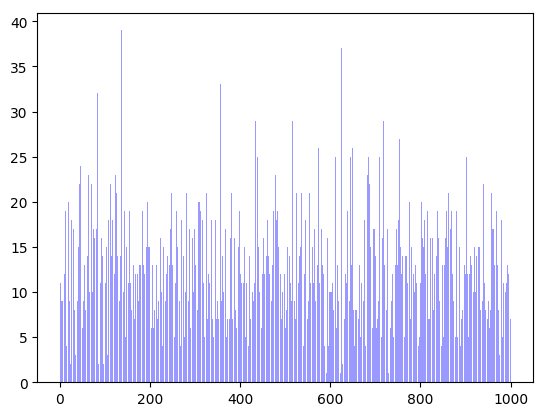

(PyObject <matplotlib.patches.Rectangle object at 0x7f0c044621d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04462810>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04462e90>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0446f550>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0446fbd0>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0447d290>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0447d910>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0447df90>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04409650>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04409cd0>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04417390>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04417a10>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04417f10>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04425750>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c04425dd0>,PyObject <matplotlib.pat

In [77]:
bar(range(1, Nb_simu_total), results, color="blue",align="center",alpha=0.4)

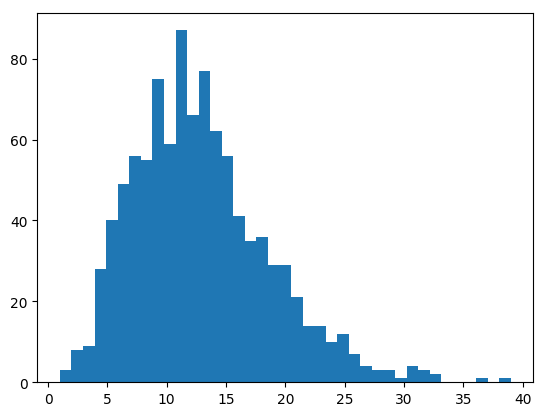

([3.0,8.0,9.0,28.0,40.0,49.0,56.0,55.0,75.0,59.0  …  1.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0],[1.0,1.97436,2.94872,3.92308,4.89744,5.87179,6.84615,7.82051,8.79487,9.76923  …  30.2308,31.2051,32.1795,33.1538,34.1282,35.1026,36.0769,37.0513,38.0256,39.0],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f0c03ab2b50>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c03a030d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c039c4690>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c039fbf10>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0395a250>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c0391d810>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c038fb850>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c038b23d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c03867c50>,PyObject <matplotlib.patches.Rectangle object at 0x7f0c03875990>  …  PyObject <matplotlib.patches.Rectangle object at 0x7f0c02c9c090>,PyObject <matplotlib.pat

In [78]:
h = plt[:hist](results, convert(Int64,maximum(results))) # Histogram
#gcf() # Needed for IJulia to plot inline